In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re,glob,os
from collections import defaultdict
import dgutils
import json

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dframe_tools as dtools
import plot_tools as ptools
import gen_resubmit as gensub

# Comment out for description of below modules
# dtools.help()
# ptools.help()
# gensub.help()

'''
Assign path of OUTPUT files and generate database
Options:
skip = int or float [int: number of line to skip, float: proportion to skip]
noenergy = 0 if you have energy estimator, 1 if you don't. 0: pick 9, 10th column 1: pick 0, 1st column
replace = 1 if you want to replace nan to zero. Be cautious to use it
'''

### If you import data from csv, put 1 here
is_csv = 1


#=========================================================================
if is_csv == 1:

    dbase = pd.read_csv('../data/SFphase_data.csv')
    dbase['filedic'] = dbase['filedic'].apply(lambda x: json.loads(x.replace("'", '"')))

else:
### from raw data
    path = '/home/sang/UVM/H4test/lindenset/'
    dbase = dtools.df_pimc(path, skip = 0, noenergy = 1, replace = 1)

dfdict = ptools.datadic(dbase)

dict_keys(['0.15,-93.0'])


In [2]:
### plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['sans'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
from matplotlib import font_manager
def what_font_path (filename):
    for p in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
        if p.find(filename) != -1:
            return p

font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'
else:
    # local path (custom)
    font_path = what_font_path('HelveticaNeue-Light-08')
    bold_font_path = what_font_path('HelveticaNeue-Bold-02')

In [3]:
### Export data
# dbase.to_csv('../data/lindenset.csv',index=False)

In [6]:
def lin_ave(subset):
    if len(subset['strain'].unique()) != 1:
        print("the subset has more than one strain data")
        return None
    else:
        subset = subset.sort_values('totN', ascending=True)
        subset = subset.reset_index()

        totNlst = np.array(subset['totN'])

        lin_lst = []
        dz_lst = []

        for idx, row in subset.iterrows():
            file = row['filedic']['lineardensity'] #file location
            with open(file,'r') as lines:
                header = lines.readline()
                header = lines.readline()
            ngridsep = int(header.split(' ')[-1])
            dz = float(header.split(' ')[-4])
            linData = np.genfromtxt(file, skip_header=2,deletechars="") #read data
            linave = np.mean(linData, axis=0)
            lin_lst.append(linave)
            dz_lst.append(dz)
            
        return totNlst, lin_lst, dz_lst

In [22]:
target = dbase[dbase['totN']==64]

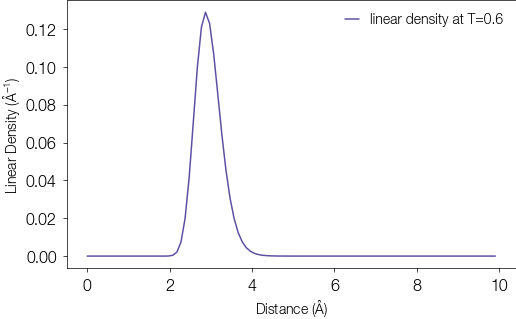

In [44]:
totNlst, lin_lst, dz_lst = lin_ave(target)
lx, ly, lz = target['boxdims'].iloc[0]

plt.style.reload_library()
fig = plt.figure('fig')
dgutils.fonts.set_custom_font(font_path)
plt.plot(np.arange(0,10-dz_lst[0],dz_lst[0]) ,lin_lst[0]*dz_lst[0]*lx*ly/target['n'].iloc[0], label=f'linear density at T=0.6')
# for i in range(len(lin_lst)):
#     print(totNlst[i])
#     plt.plot(np.arange(0,10-dz_lst[i],dz_lst[i]) ,lin_lst[i], label=f'size={totNlst[i]}')
plt.legend()
plt.xlabel('Distance'+r' (${\rm \AA}$)')
plt.ylabel('Linear Density' +r' (${\rm \AA}^{-1}$)')
fig.savefig('../figures/linden15-93.pdf')

In [43]:
sum(lin_lst[0]*dz_lst[0]*lx*ly/target['n'].iloc[0])

0.9980996619806077